In [1]:
from templates import *

c:\Users\dmrar\Desktop\WS23-24\computational surgineering\env-diffae\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SyntaxError: invalid syntax (dataset.py, line 816)

: 

In [3]:
device = 'cuda'
conf = mixed_us_training()
# print(conf.name)
model = LitModel(conf)
state = torch.load(R'checkpoints\mixed_cosine\last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device)

Global seed set to 0
Global seed set to 0


Model params: 91.89 M


BeatGANsAutoencModel(
  (time_embed): TimeStyleSeperateEmbed(
    (time_embed): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (style): Identity()
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (cond_emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=64, bias=True)
     

In [5]:
data = RealUSDataset(R'datasets\real_us')
batch = torch.stack([
    data[0]['img'],
    data[1]['img'],
])

In [6]:
len(data)

7866

In [7]:
# make pytroch dataloader
loader = DataLoader(data, batch_size=128, shuffle=False)

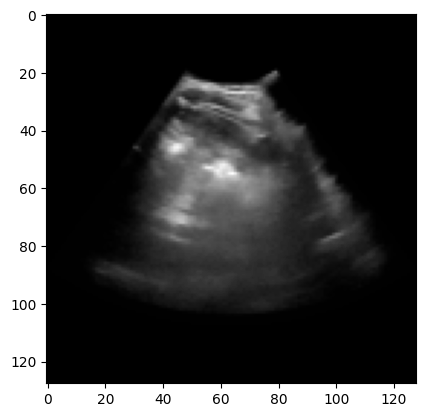

In [8]:
import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]), cmap='gray')

In [9]:
img_encodings = {}
for i, batch in enumerate(loader):
    cond = model.encode(batch['img'].to('cuda'))
    
    for j in range(cond.shape[0]):
        # print(i * 128 + j)
        img_encodings[i * 128 + j] = cond[j].detach().cpu().numpy()

In [10]:
import numpy as np

def cosine_similarity_matrix(X):
    # Compute dot product of all pairs of vectors
    dot_product = np.dot(X, X.T)
    # Compute the norm of each vector
    norm = np.linalg.norm(X, axis=1)
    # Compute the outer product of norms
    norm_outer = np.outer(norm, norm)
    # Compute cosine similarity matrix
    similarity_matrix = dot_product / norm_outer
    return similarity_matrix

def euclidean_distance_matrix(X):
    # Compute pairwise Euclidean distances
    distances = np.sqrt(np.sum((X[:, np.newaxis] - X) ** 2, axis=-1))
    return distances

In [11]:
latent_representations_array = np.array(list(img_encodings.values()))
cosine_similarity = cosine_similarity_matrix(latent_representations_array)
# euclidean_distance = euclidean_distance_matrix(latent_representations_array)

def find_top_similar_cosine(similarity_matrix, top_x):
    np.fill_diagonal(similarity_matrix, -np.inf)  # Set diagonal elements to -infinity to exclude self-similarity
    indices = np.argpartition(similarity_matrix.flatten(), -top_x)[-top_x:]
    top_indices = np.unravel_index(indices, similarity_matrix.shape)
    return top_indices

top_x = 50
top_indices_cosine = find_top_similar_cosine(cosine_similarity, top_x)
print("Indices of the top", top_x, "most similar vectors (Cosine Similarity):", top_indices_cosine)


Indices of the top 50 most similar vectors (Cosine Similarity): (array([1352, 1353, 4726, 4725, 2205, 2204, 3190, 2568, 3191, 4696, 4680,
       4679, 2567, 4695, 7843, 1793, 3212, 1792, 7844, 5947, 4618, 3211,
       5946, 4617, 3219, 3218, 3183, 2739, 3184,  129, 3218, 6858, 6857,
       3217, 2738, 4716, 3217,  131, 4717,  131,  131,  130,  130,  130,
        129,  128,  128,  128, 3219,  129], dtype=int64), array([1353, 1352, 4725, 4726, 2204, 2205, 3191, 2567, 3190, 4695, 4679,
       4680, 2568, 4696, 7844, 1792, 3211, 1793, 7843, 5946, 4617, 3212,
       5947, 4618, 3217, 3217, 3184, 2738, 3183,  128, 3219, 6857, 6858,
       3219, 2739, 4717, 3218,  130, 4716,  129,  128,  131,  129,  128,
        131,  129,  130,  131, 3218,  130], dtype=int64))


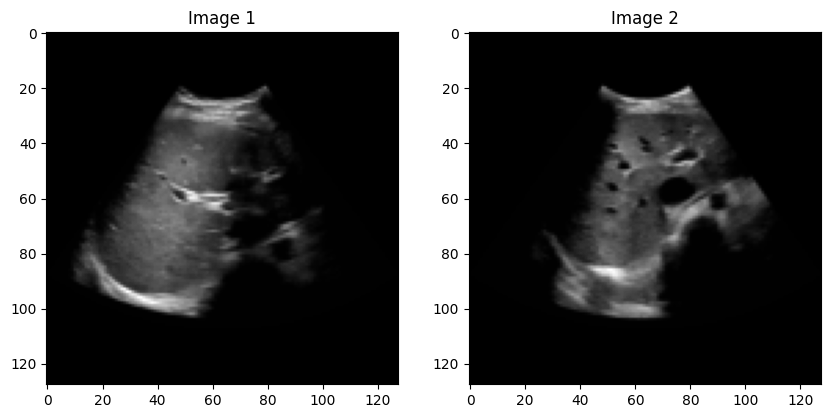

In [12]:
img1 = data[2735] 
img2 = data[3219]

#create a figure to display the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#display the first image
axes[0].imshow(img1['img'].permute([1, 2, 0]), cmap='gray')
axes[0].set_title('Image 1')
#display the second image
axes[1].imshow(img2['img'].permute([1, 2, 0]), cmap='gray')
axes[1].set_title('Image 2')
plt.show()


torch.Size([2, 512])


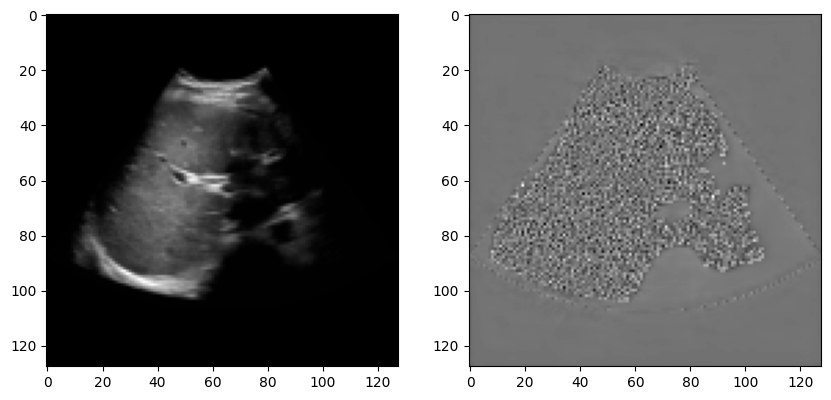

In [13]:
cond1 = img_encodings[2735]
cond2 = img_encodings[3219]
cond = torch.stack([torch.tensor(cond1), torch.tensor(cond2)]).to('cuda')
print(cond.shape)
batch = torch.stack([
    img1['img'],
    img2['img'],
])

xT = model.encode_stochastic(batch.to(device), cond, T=1000)

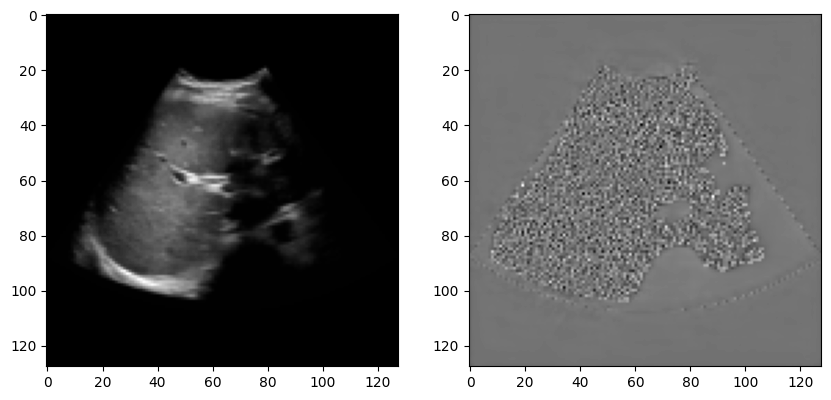

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = batch
ax[0].imshow(ori[0].permute(1, 2, 0).cpu(), cmap='gray')
ax[1].imshow(xT[0].permute(1, 2, 0).cpu(), cmap='gray')

In [17]:
alpha = torch.tensor(np.linspace(0, 1, 10, dtype=np.float32)).to(cond.device)
intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

theta = torch.arccos(cos(xT[0], xT[1]))
x_shape = xT[0].shape
intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
intp_x = intp_x.view(-1, *x_shape)

pred = model.render(intp_x, intp, T=1000)

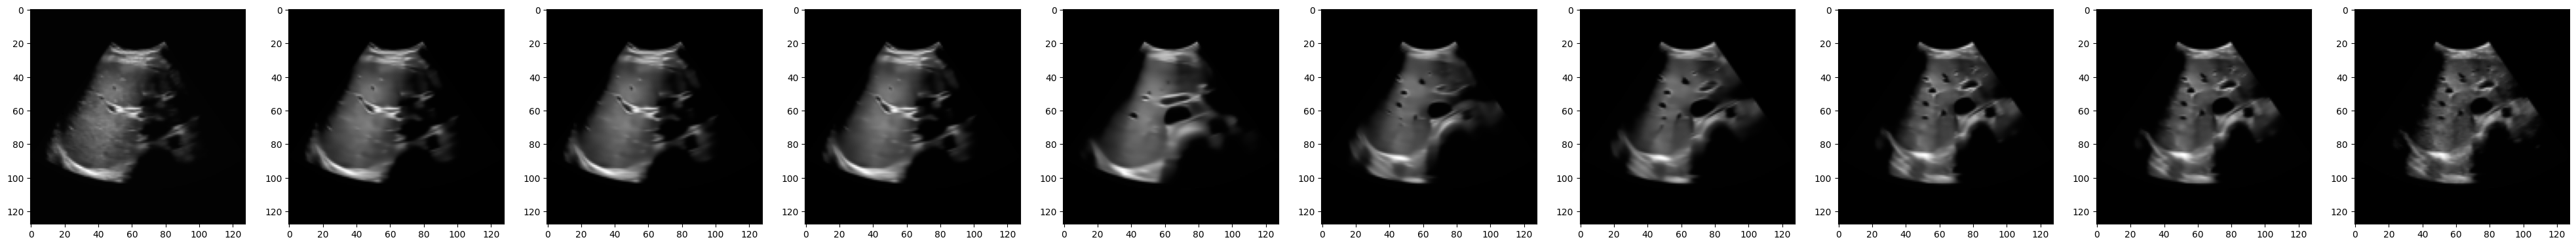

In [18]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 10, figsize=(5*10, 5))
for i in range(len(alpha)):
    ax[i].imshow(pred[i].permute(1, 2, 0).cpu(), cmap='gray')

# Mixed interpolation

In [68]:
from sklearn.metrics.pairwise import cosine_similarity
import pickle

In [24]:
real_dataset = RealUSDataset(R'datasets\real_us')
sim_dataset = SimUSDataset(R'datasets\CT_labelmaps')

real_loader = DataLoader(real_dataset, batch_size=128, shuffle=False)
sim_loader = DataLoader(sim_dataset, batch_size=128, shuffle=False)

### Real encodings

In [32]:
real_img_encodings = {}
for i, batch in enumerate(real_loader):
    cond = model.encode(batch['img'].to('cuda'))
    for j in range(cond.shape[0]):
        # print(i * 128 + j)
        real_img_encodings[i * 128 + j] = cond[j].detach().cpu().numpy()

### Simulated encoding

In [33]:
sim_img_encodings = {}
for i, batch in enumerate(sim_loader):
    cond = model.encode(batch['img'].to('cuda'))
    for j in range(cond.shape[0]):
        # print(i * 128 + j)
        sim_img_encodings[i * 128 + j] = cond[j].detach().cpu().numpy()

In [34]:
real_latent_rep = np.array([np.array(value) for value in real_img_encodings.values()])
sim_latent_rep = np.array([np.array(value) for value in sim_img_encodings.values()])
print(real_latent_rep.shape, sim_latent_rep.shape)

(7866, 512) (12000, 512)


In [35]:
similarities = cosine_similarity(real_latent_rep, sim_latent_rep)
best_indices = np.argmax(similarities, axis=1)
image_pairs = [(real_latent_rep[i], sim_latent_rep[j]) for i, j in enumerate(best_indices)]

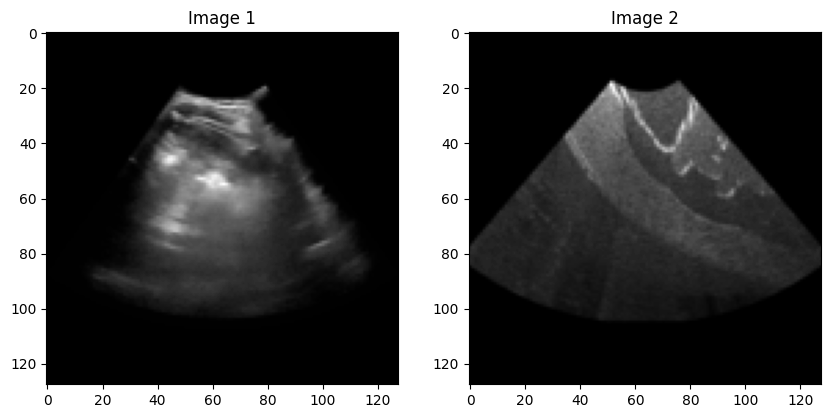

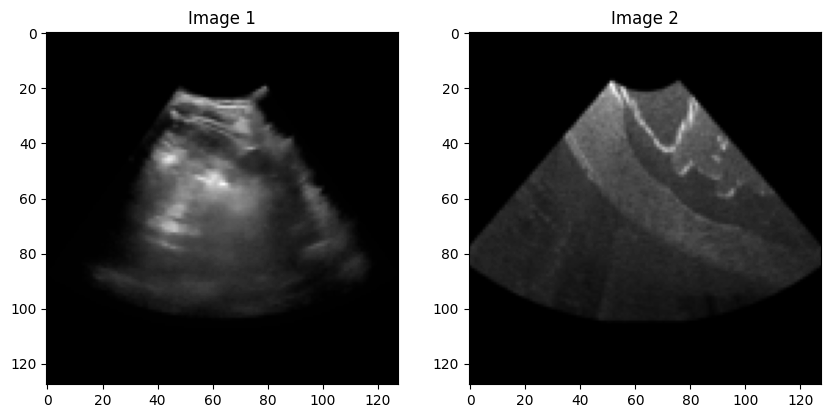

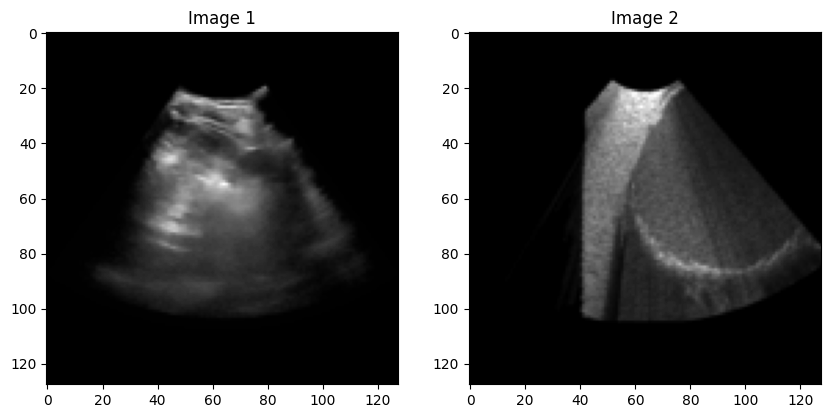

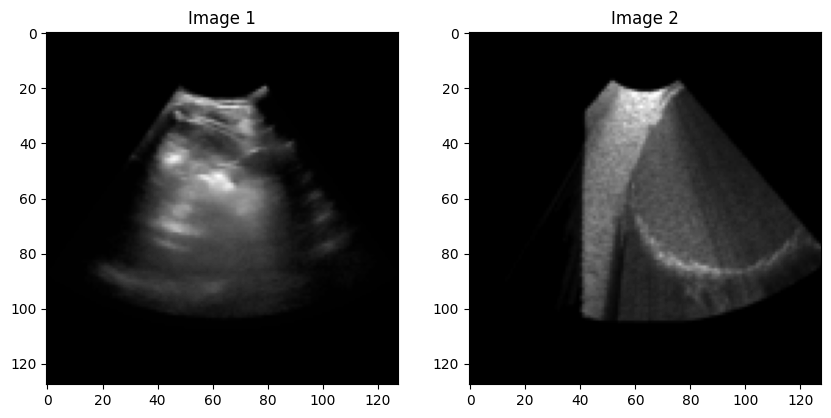

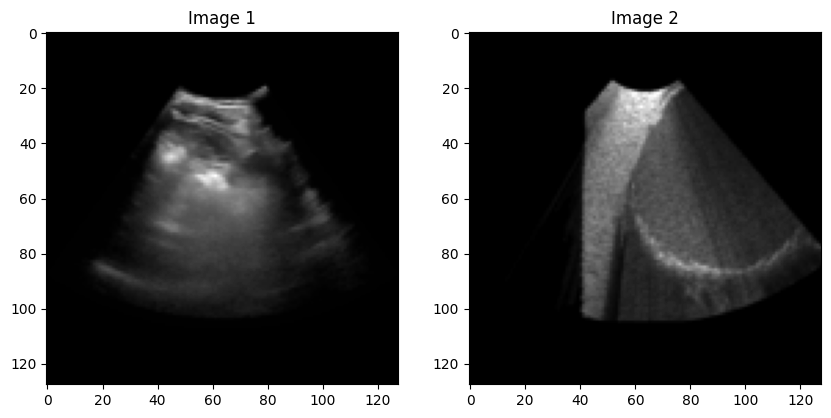

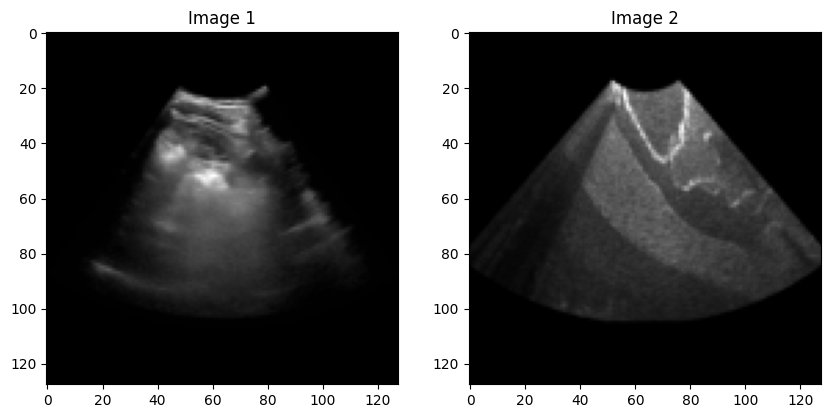

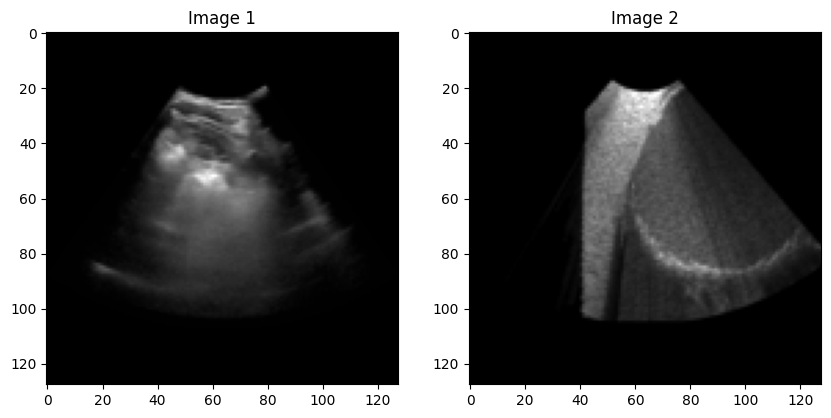

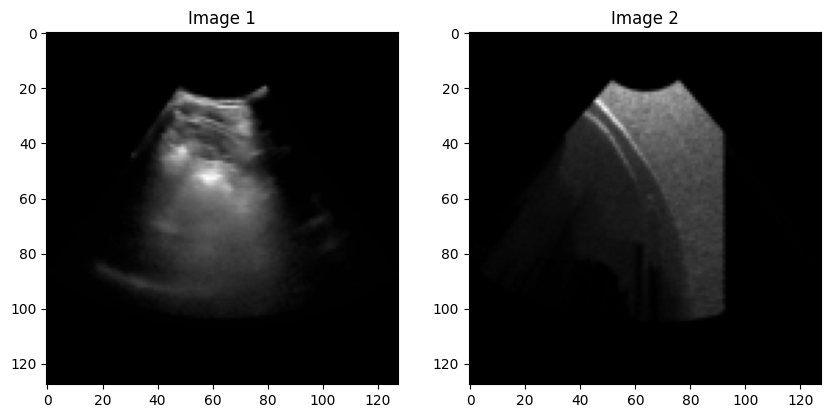

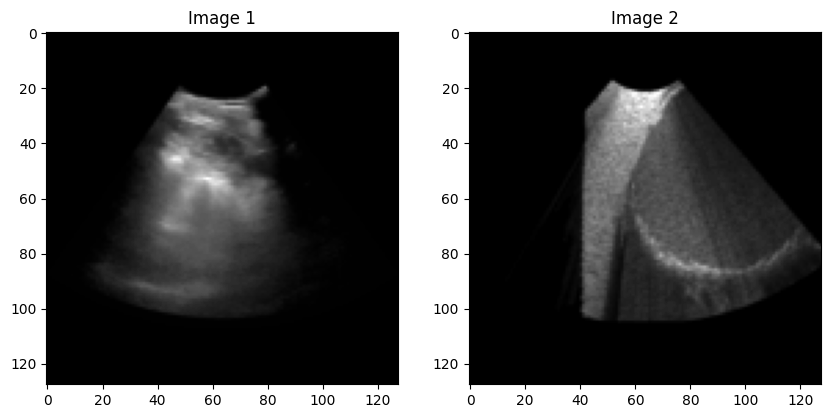

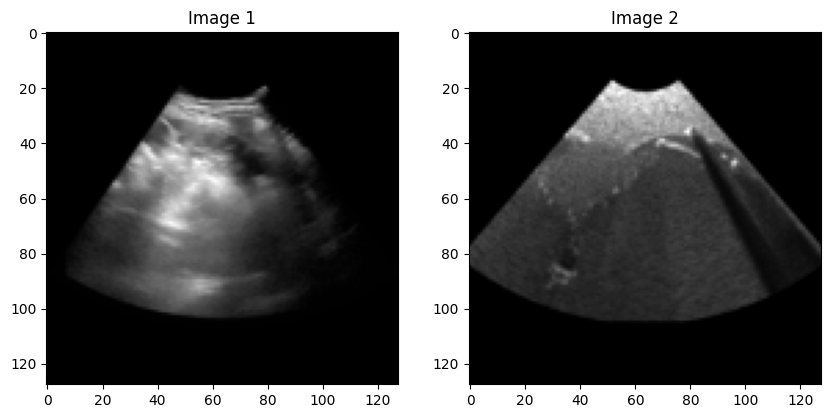

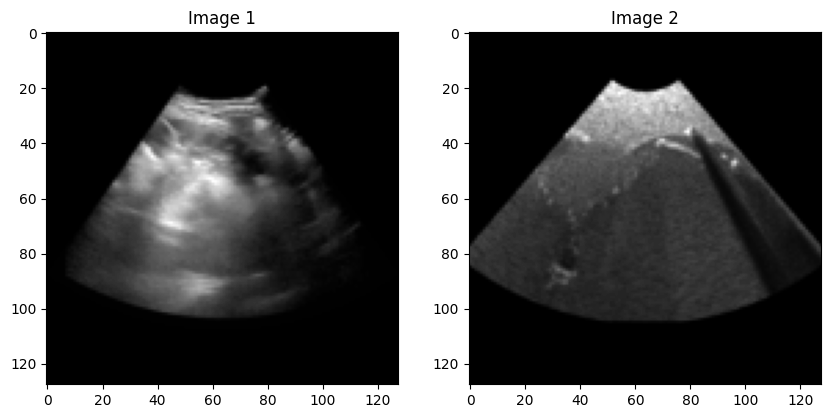

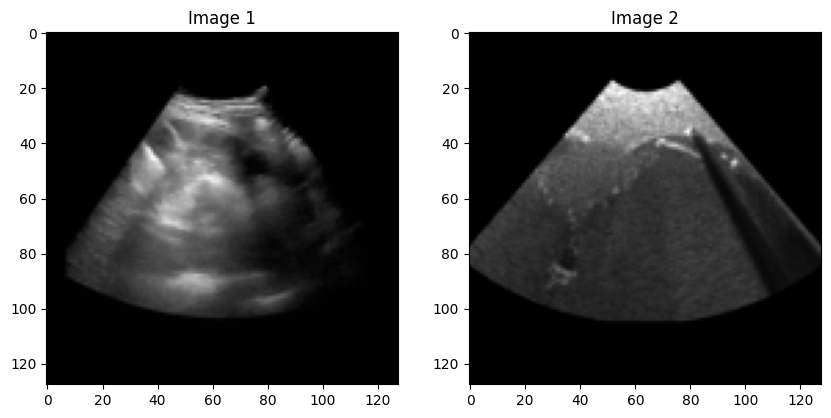

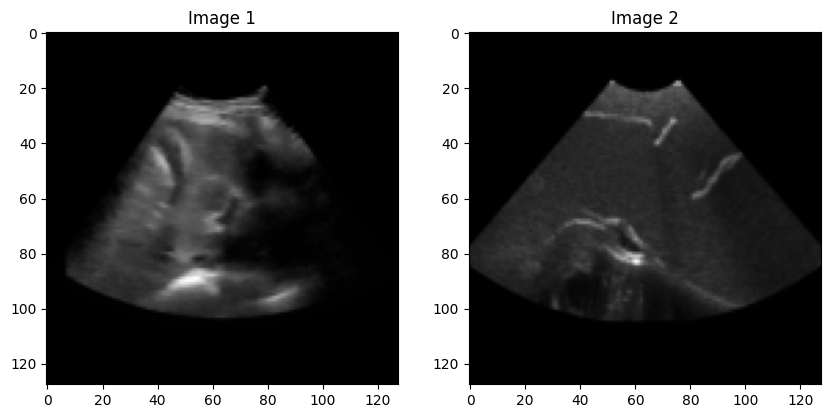

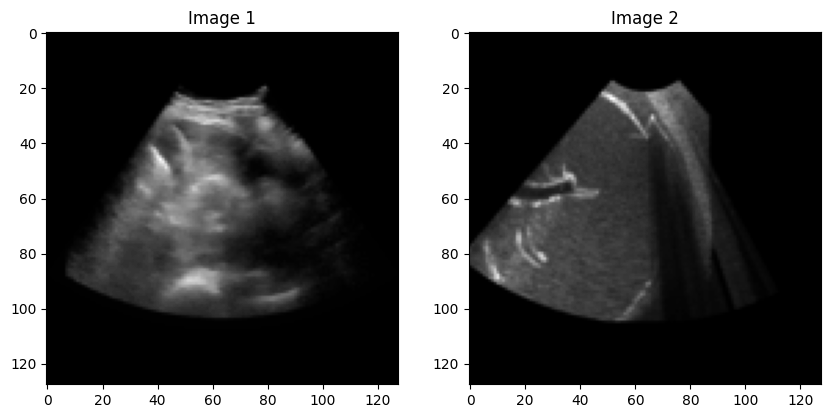

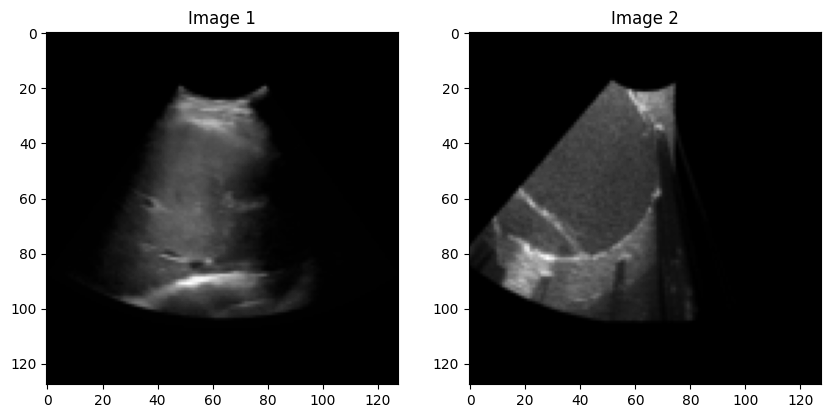

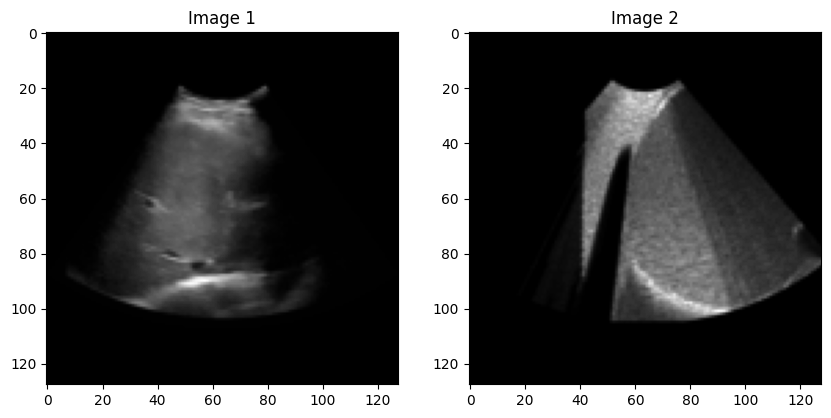

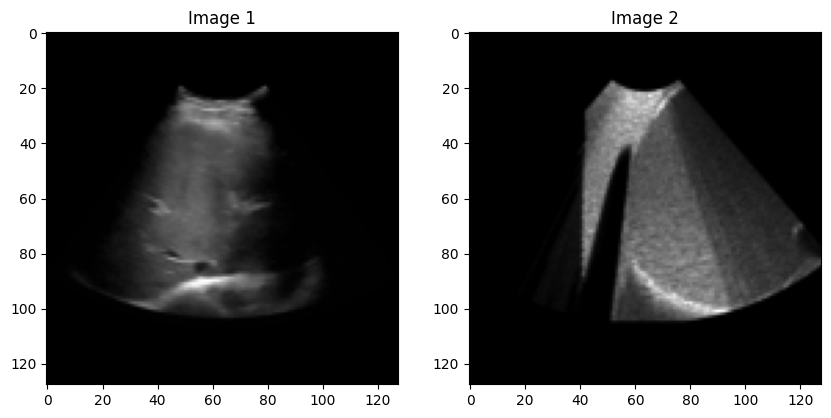

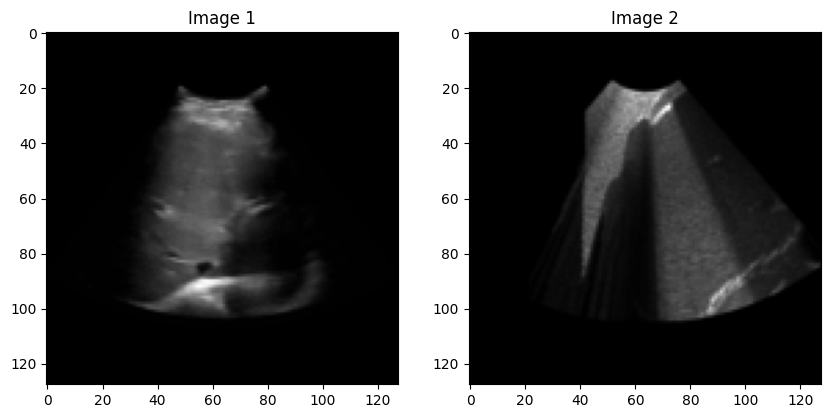

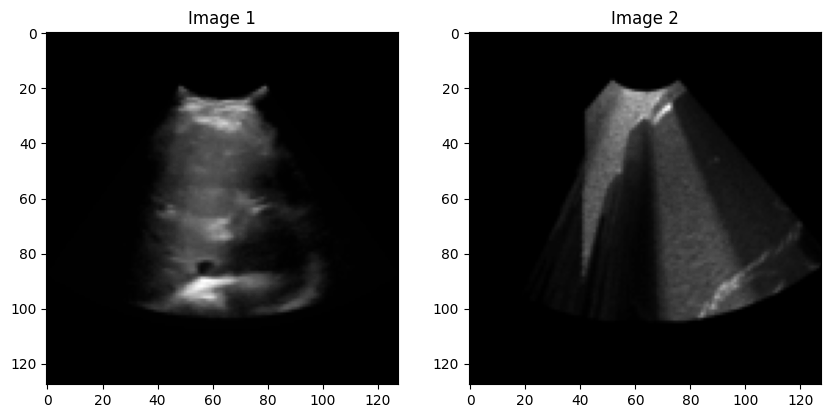

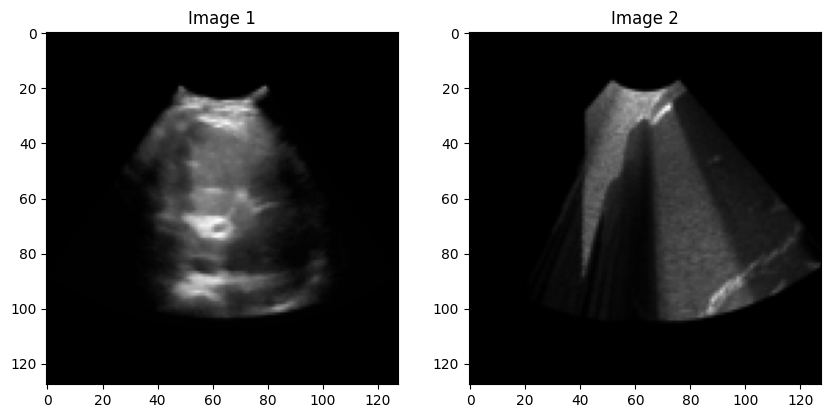

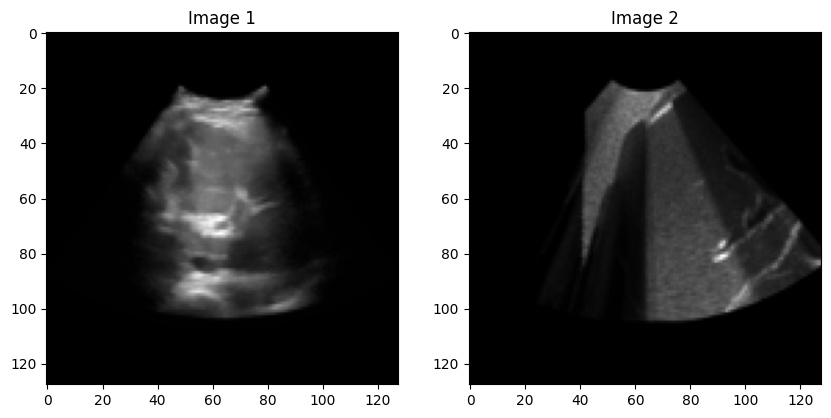

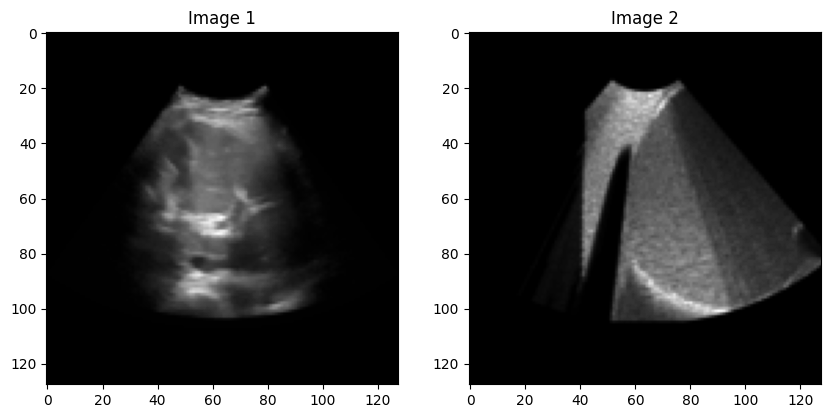

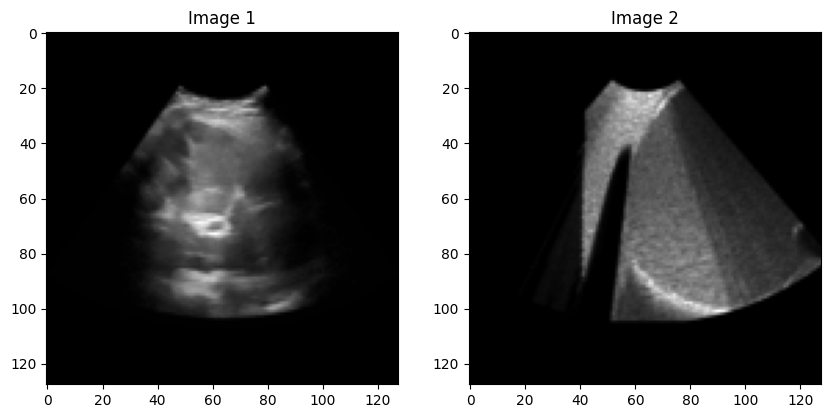

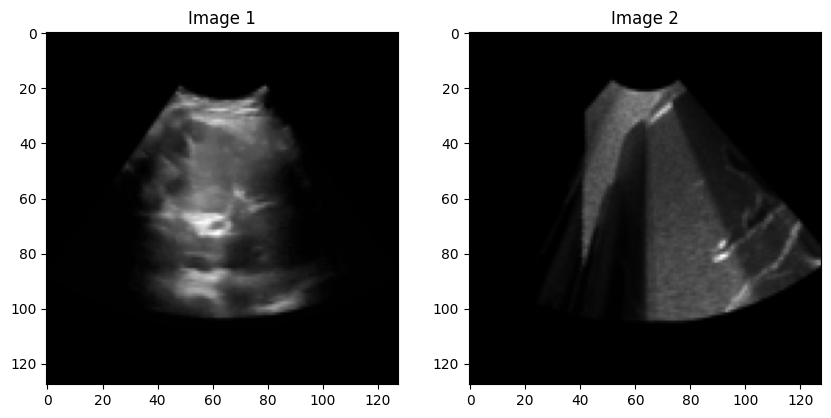

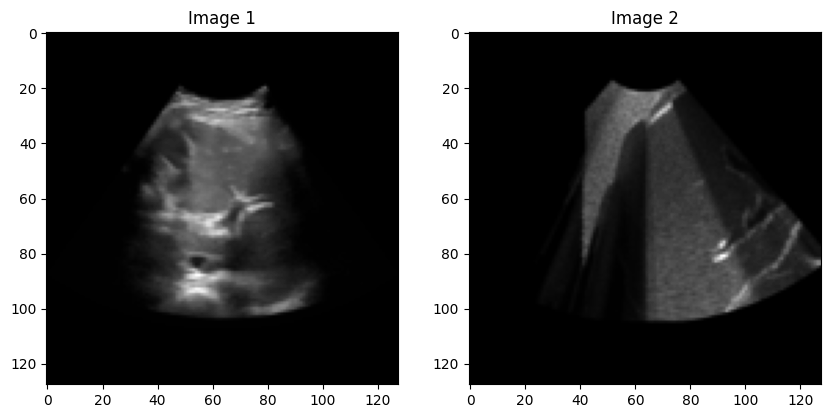

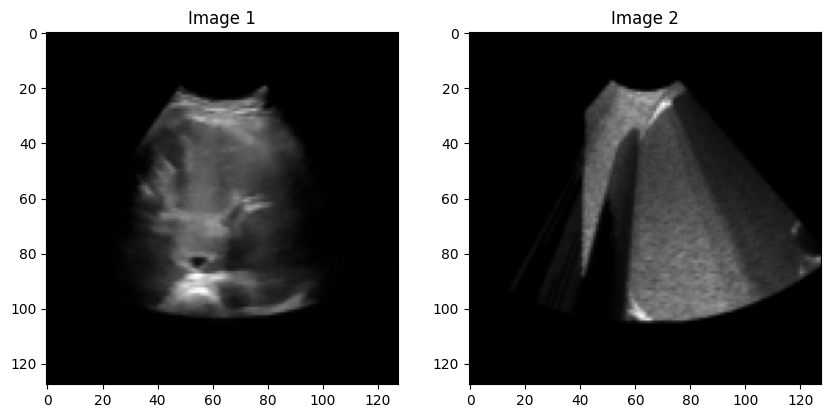

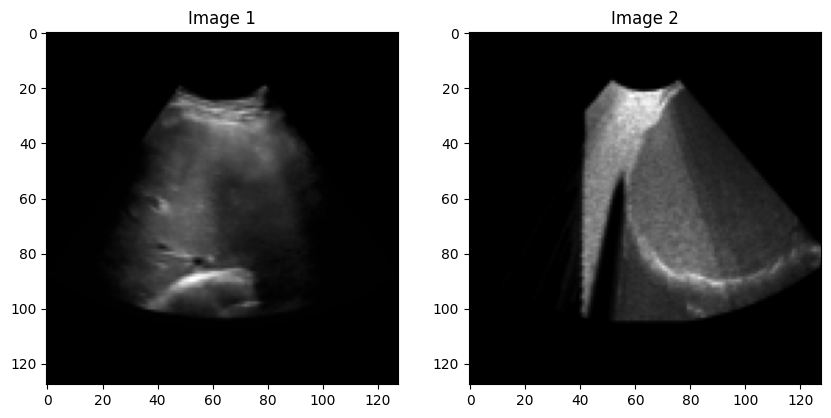

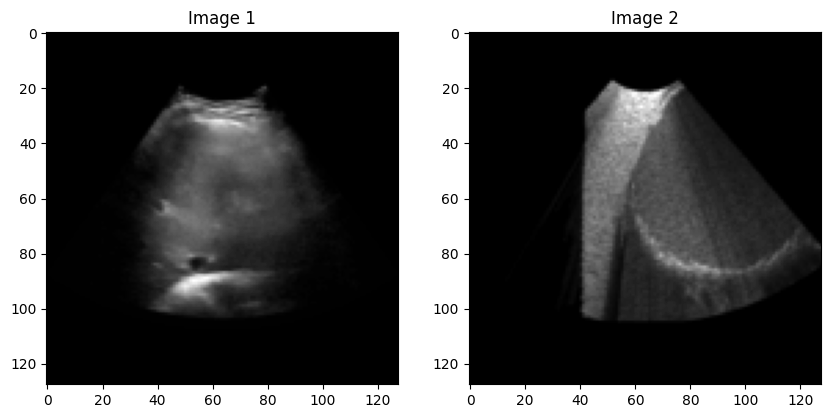

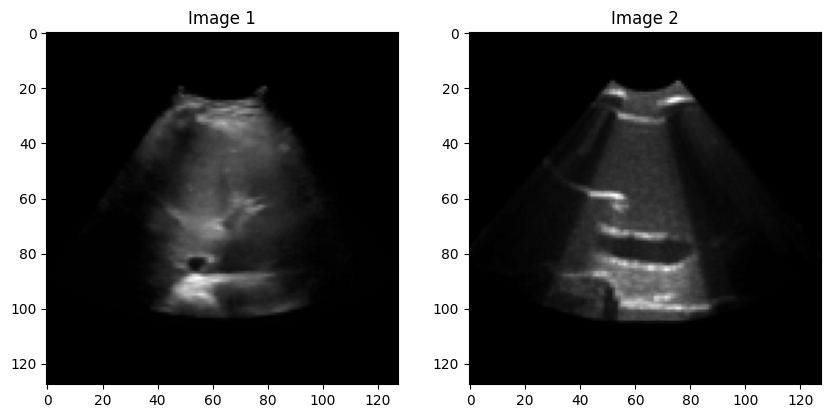

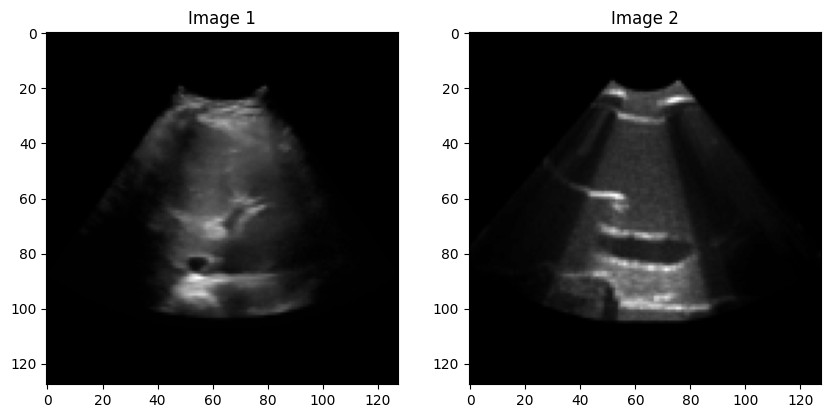

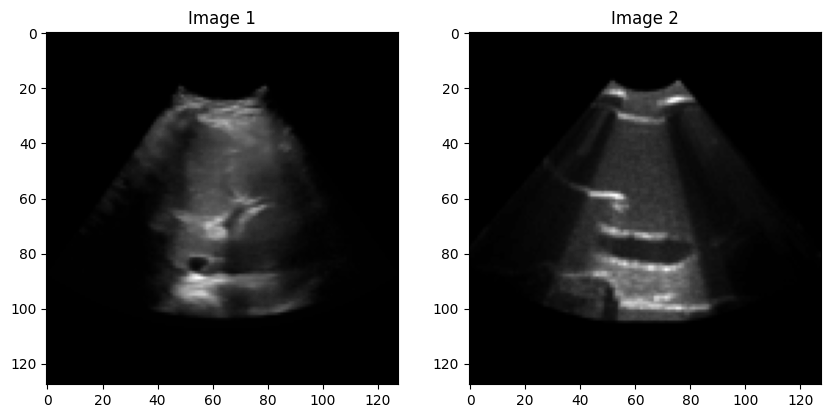

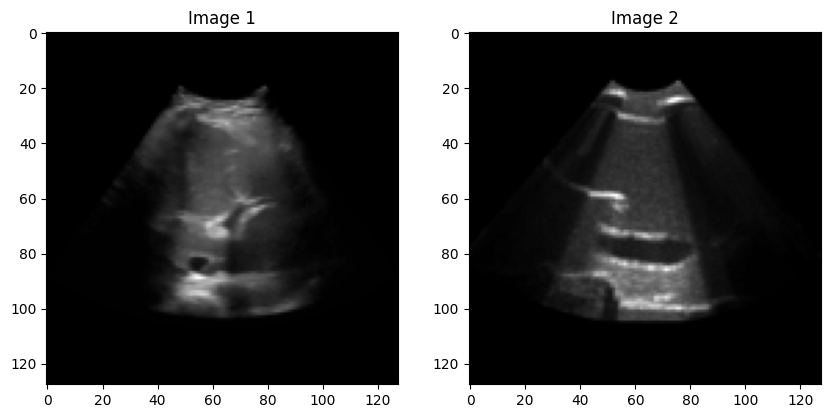

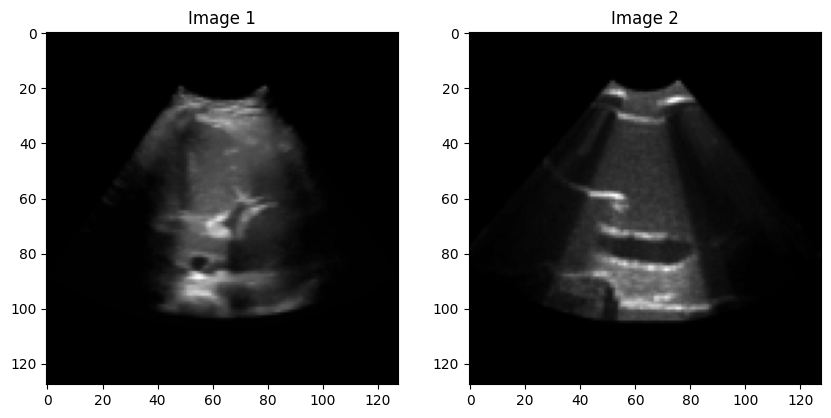

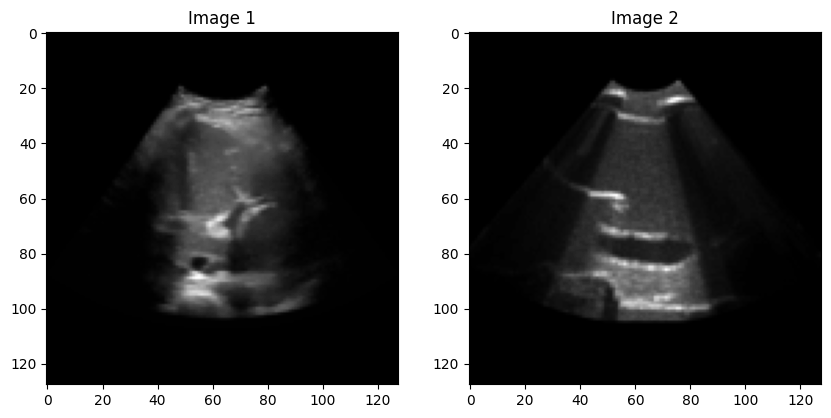

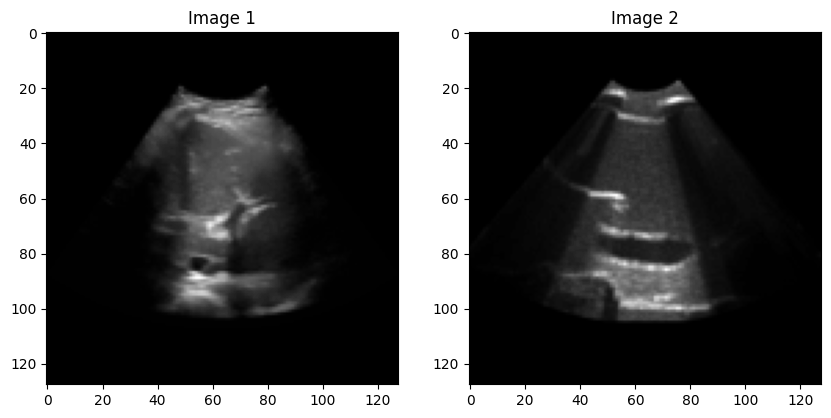

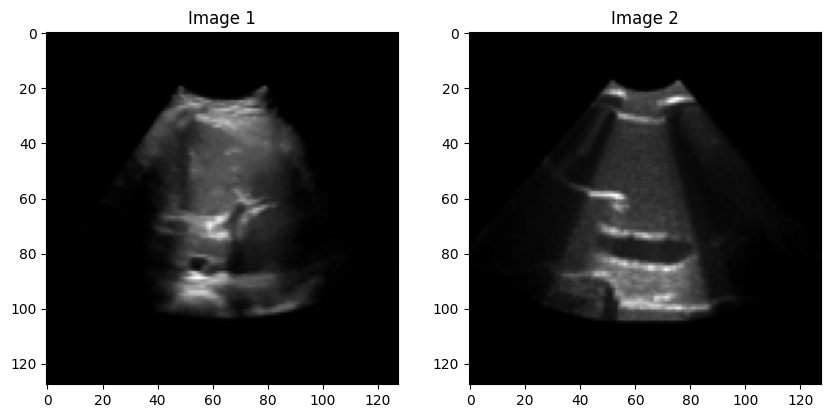

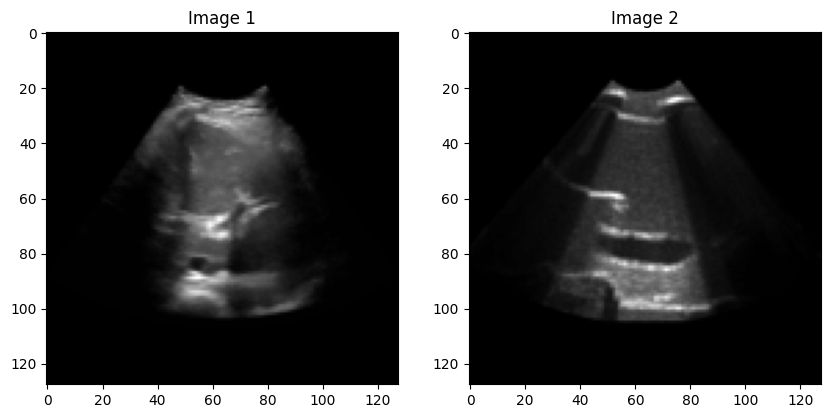

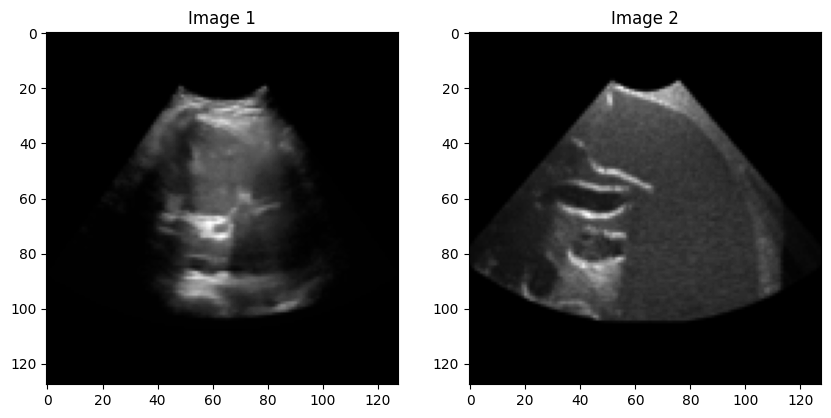

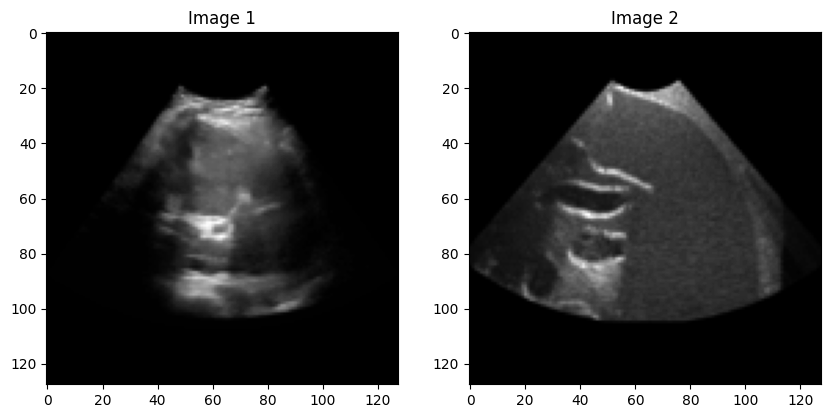

KeyboardInterrupt: 

<Figure size 1000x500 with 0 Axes>

In [45]:
for i, j in enumerate(best_indices):
    real_image = real_dataset[i]
    sim_image = sim_dataset[j]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    #display the first image
    axes[0].imshow(real_image['img'].permute([1, 2, 0]), cmap='gray')
    axes[0].set_title('Image 1')
    #display the second image
    axes[1].imshow(sim_image['img'].permute([1, 2, 0]), cmap='gray')
    axes[1].set_title('Image 2')
    plt.show()

In [75]:
interpolated_images = []
for i,j in enumerate(best_indices):
    cond1 = real_latent_rep[i]
    cond2 = sim_latent_rep[j]
    cond = torch.stack([torch.tensor(cond1), torch.tensor(cond2)]).to('cuda')
    batch = torch.stack([
    real_dataset[i]['img'],
    sim_dataset[j]['img'],    
    ])
    xT = model.encode_stochastic(batch.to('cuda'), cond, T=1000)

    alpha = torch.tensor(np.linspace(0, 1, 10, dtype=np.float32)).to(cond.device)
    intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

    def cos(a, b):
        a = a.view(-1)
        b = b.view(-1)
        a = F.normalize(a, dim=0)
        b = F.normalize(b, dim=0)
        return (a * b).sum()

    theta = torch.arccos(cos(xT[0], xT[1]))
    x_shape = xT[0].shape
    intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
    intp_x = intp_x.view(-1, *x_shape)

    pred = model.render(intp_x, intp, T=1000)
    interpolated_images.append(((i,j), pred))
    if i == 100:
        with open(R'checkpoints\mixed_us_training_cosine\interpolated_images.pkl', 'wb') as file:
            pickle.dump(interpolated_images, file)
        break

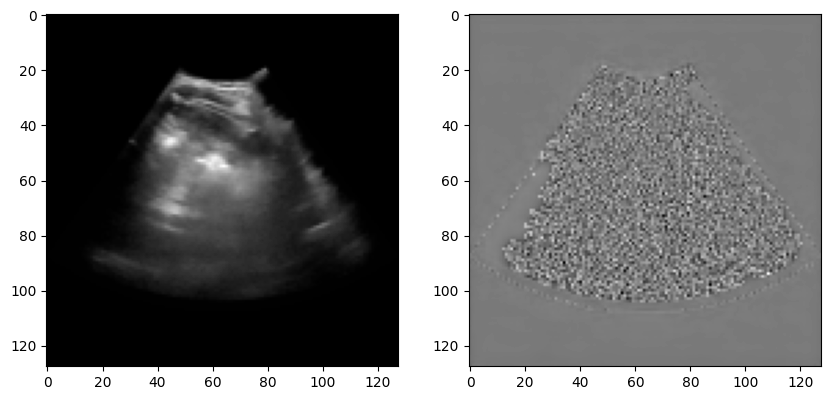

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = batch
ax[0].imshow(ori[0].permute(1, 2, 0).cpu(), cmap='gray')
ax[1].imshow(xT[0].permute(1, 2, 0).cpu(), cmap='gray')
plt.show()

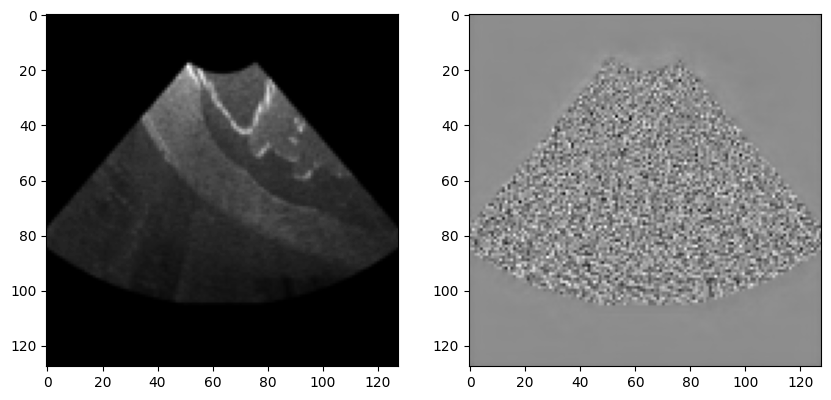

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = batch
ax[0].imshow(ori[1].permute(1, 2, 0).cpu(), cmap='gray')
ax[1].imshow(xT[1].permute(1, 2, 0).cpu(), cmap='gray')
plt.show()

In [ ]:
with open(R'checkpoints\mixed_us_training_cosine\interpolated_images.pkl', 'wb') as file:
    interp_imgs = pickle.load(file)

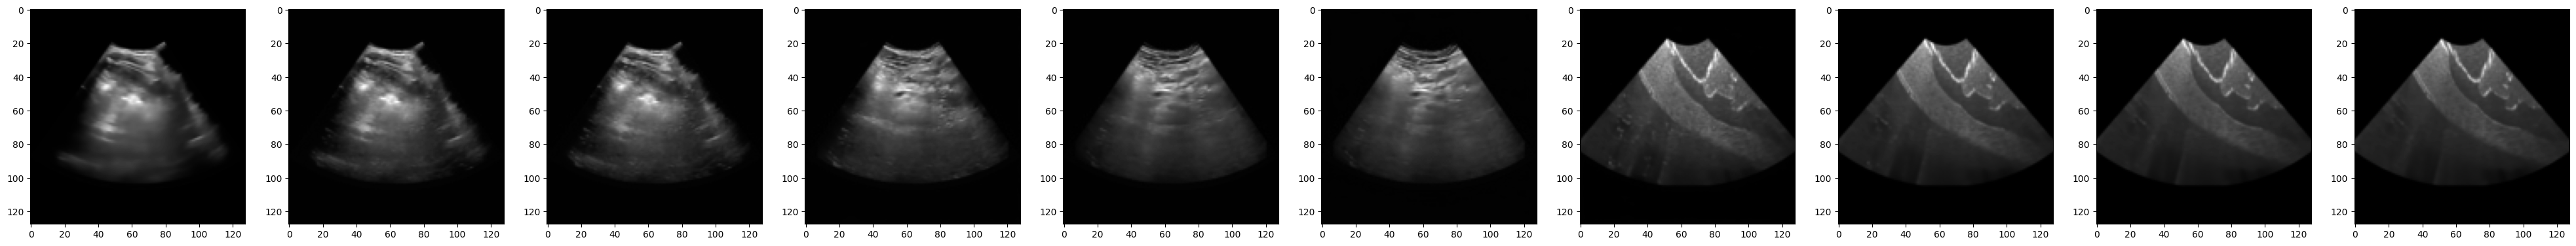

In [60]:
pred = interp_imgs[0][0]
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 10, figsize=(5*10, 5))
for i in range(len(alpha)):
    ax[i].imshow(pred[i].permute(1, 2, 0).cpu(), cmap='gray')